In [1]:
#SINGLE LAYER PERCEPTRON

In [2]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit
import sys

In [3]:
class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2
    def _sigmoid(self, z):
        # expit is equivalent to 1.0/(1.0 + np.exp(-z))
        return expit(z)
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)
    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2)\
                                + np.sum(w2[:, 1:] ** 2))
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum()\
                                + np.abs(w2[:, 1:]).sum())
    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)
        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))
        return grad1, grad2
    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)
            if print_progress:
                sys.stderr.write(
                    '\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_data = X_data[idx], y_data[idx]
            mini = np.array_split(range(
                y_data.shape[0]), self.minibatches)
            for idx in mini:
                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(
                    X[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)
                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)
                # update weights
                delta_w1, delta_w2 = self.eta * grad1,\
                self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
        return self

In [4]:
data = pd.read_csv('C:/Users/PRIYANSHU SHARMA/Desktop/PRIYANSHU/6 STUDY/6 SEMSTER/MACHINE LEARNING/LAB/breast.csv')
data.head()

,1000025,5,1,1.1,1.2,2,1.3,3,1.4,1.5,2.1
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [5]:
colnames=['ID', 'RADIUS', 'TEXTURE', 'PERIMETER', 'AREA', 'SMOOTHNESS', 'COMPACTNESS', 'CONCAVITY', 'CONCAVE', 'SYMMETRY', 'FRACTAL']
data = pd.read_csv('C:/Users/PRIYANSHU SHARMA/Desktop/PRIYANSHU/6 STUDY/6 SEMSTER/MACHINE LEARNING/LAB/breast.csv', names=colnames, header=None)

In [6]:
data.head()

,ID,RADIUS,TEXTURE,PERIMETER,AREA,SMOOTHNESS,COMPACTNESS,CONCAVITY,CONCAVE,SYMMETRY,FRACTAL
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [7]:
print(data.columns)

Index(['ID', 'RADIUS', 'TEXTURE', 'PERIMETER', 'AREA', 'SMOOTHNESS',
       'COMPACTNESS', 'CONCAVITY', 'CONCAVE', 'SYMMETRY', 'FRACTAL'],
      dtype='object')


In [8]:
data.describe()

,ID,RADIUS,TEXTURE,PERIMETER,AREA,SMOOTHNESS,COMPACTNESS,CONCAVITY,CONCAVE,SYMMETRY,FRACTAL
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.486409,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.621929,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [1]:
from sklearn.cross_validation import train_test_split
X = data.iloc[0:, [1,2,3,4,5,6,7]].values
X_train,X_test,Y_train,Y_test = train_test_split(X,data['FRACTAL'], test_size=0.3, random_state=0)


C:\Users\PRIYANSHU SHARMA\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: name 'data' is not defined

In [10]:
nn = NeuralNetMLP(n_output=10,
                  n_features=X_train.shape[1],
                  n_hidden=25,
                  l2=0.1,
                  l1=0.0,
                  epochs=1000,
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  shuffle=True,
                  minibatches=50,
                  random_state=1)

In [11]:
nn.fit(X_train, Y_train, print_progress=True)

Epoch: 1/1000C:\Users\PRIYANSHU SHARMA\Anaconda3\lib\site-packages\pandas\core\series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
Epoch: 1000/1000

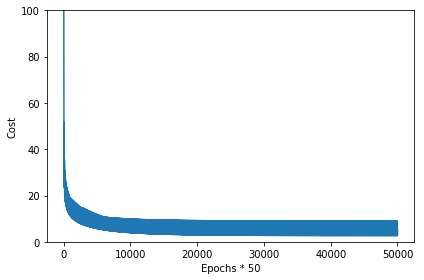

In [12]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 100])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
plt.show()

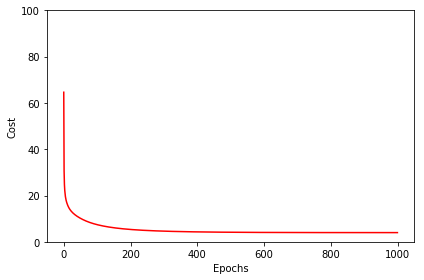

In [13]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)),
cost_avgs,
color='red')
plt.ylim([0, 100])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [14]:
Y_train_pred = nn.predict(X_train)
acc = np.sum(Y_train == Y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.96%


In [15]:
Y_test_pred = nn.predict(X_test)
acc = np.sum(Y_test == Y_test_pred, axis=0) / X_test.shape[0]
print('Testing accuracy: %.2f%%' % (acc * 100))

Testing accuracy: 93.81%
